# Attributions

Emma Fountain completed this project as an individual. I wrote all the code excluding 3rd-party libraries installed with pip and the model implementations.

# Code Setup

The codebase associated with this report is found at

This Jupyter Notebook requires a number of 3rd-party libraries. Please run `pip install -r requirements.txt` at least once

The RetinaFace pytorch implementation that I use relies on locally-stored weights too large to store in a git repository and they must be downloaded and installed into the directory structure as indicated below

> Download the `Resnet50_Final.pth` file from [this](https://drive.google.com/drive/folders/1oZRSG0ZegbVkVwUd8wUIQx8W7yfZ_ki1) google drive folder and copy/move it to `Project/Pytorch_Retinaface/weights/Resnet50_Final.pth`

# Libraries
I utilize public pre-trained `pytorch` implementations of RetinaFace [[1](#References)] for face localisation and Facenet [[2](#References)] for face recognition, both of which are included as submodules in the project git repository. The RetinaFace implementation was modified slightly to provide a more accessible API.

I also use various ML/CV-related libraries including `torchvision`, `opencv`, `numpy`, and `sklearn`. For visualizations I use `matplotlib` and `ipympl` to add interactivity.

In addition to 3rd-party libraries, I utilize a custom class called `DictList` which I have found useful in previous projects for tracking and aggregating metrics.

In [1]:
%matplotlib widget
import os
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from DictList import DictList, DictArr
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization, training

In [2]:
data_dir = 'Celebrity Faces Dataset'

batch_size = 32
epochs = 15
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


# Face Detection

I perform face recognition in 2 steps, beginning with face detection. I iterate through the data directory and detect faces in eacah image using RetinaFace. RetinaFace is a feature-pyramid based deep CNN with independent context modules on 5 pyramid levels trained using a custom multi-task objective function on positive samples and scale-specific anchors. It was trained on the WIDER FACE dataset [[3](#References)] with data augmentation including random cropping, random horizontal flips, and photo-metric colour distortion [[1](#References)].

I then use these detections to crop to the face and resize the resulting image into a standard 160x160 shape before saving this image into a new directory structure identical to the source data directory except the root folder name has `_cropped` appended. 

For example, the file `Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg` will be processed and saved to `Celebrity Faces Dataset_cropped/Angelina Jolie/001_fe3347c0.jpg`

> For additional information see `Preprocessing.py`

In [3]:
from Preprocessing import cropFaces
dest = data_dir + "_cropped"
cropFaces(data_dir, dest, regenerate=False)

Checking Celebrity Faces Dataset_cropped
Already populated!
{'Johnny Depp': 100, 'Jennifer Lawrence': 100, 'Sandra Bullock': 100, 'Tom Hanks': 100, 'Tom Cruise': 100, 'Robert Downey Jr': 100, 'Nicole Kidman': 100, 'Denzel Washington': 100, 'Megan Fox': 100, 'Scarlett Johansson': 200, 'Leonardo DiCaprio': 100, 'Kate Winslet': 100, 'Angelina Jolie': 100, 'Hugh Jackman': 100, 'Will Smith': 100, 'Brad Pitt': 100, 'Natalie Portman': 100}


# Data Loading

After performing face detection, I load in our data for face recognition. I first convert the data into a standard format by converting the data to `np.float32` then to `torch.Tensor`s. 

Since this is a small dataset I utilize data augmentation when training. I randomly vary HSVL values, flip horizontally, grayscale, and downsample. I considered also using generative data augentation but decided that the time cost to implement it was not worth the marginal improvements over basic methods [[4](#References)]

Finally, I use the `fixed_image_standardization` function from FaceNet to transform the data into a pre-defined range.

Since I only use data augmentation for training, I create 2 different datasets, one with only the standardization transforms, and one including the data augmentation transforms.

In [4]:
class RandomDownscale(object):
    def __init__(self, size_range=(0.1, 1), p=(0.5)):
        self.min_scale, self.max_scale = size_range
        self.p = p
    
    def __call__(self, img):
        if torch.rand(1).item() >= self.p:
            return img
        
        scale = torch.rand(1).item()*(self.max_scale - self.min_scale) + self.min_scale
        h, w = img.shape[-2:]
        new_shape = np.round(np.array([h*scale, w*scale])).astype(int)
        img_downscaled = transforms.functional.resize(img, new_shape)
        img_upscaled = transforms.functional.resize(img_downscaled, (h, w))
        return img_upscaled

In [5]:
aug_transforms = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    RandomDownscale()
])
def getTransform(trans=transforms.Lambda(lambda x: x)):
    return transforms.Compose([
        np.float32,
        transforms.ToTensor(),
        trans,
        fixed_image_standardization
    ])

train_dataset = datasets.ImageFolder(
    data_dir + '_cropped', 
    transform=getTransform(aug_transforms)
)
eval_dataset = datasets.ImageFolder(
    data_dir + '_cropped', 
    transform=getTransform()
)
classes = train_dataset.classes

# Face Recognition

To simplify fine-tuning I use a simple `Trainer` wrapper class that handles basic training. To easily re-load the model I define the `getResnet` function which I can call and pass to the `model` parameter of a new `Trainer` object. 

By default when you run the `Trainer` class it returns an empty `DictList`. To extract data from the training loop, you must pass a "Data Hook" function that takes 2 arguments:

- `data` is the `DictList` object, which should be modified in the data hook function
- `bdata` is a dictionary containing the following information for each batch: `x` (the input batch), `y` (the batch labels), `y_probs` (the model output probability distributions), and `loss_grad` (the loss tensor)

> For more information on the `Trainer` class see `Trainer.py`

I define a number of data hooks below to extract different information for different parts of the training loop.

# FaceNet

The particular model I use for face recognition is FaceNet utilizing an Inception Resnet V1 backbone which is a Deep Convolutional Neural Network that uses multi-scale feature maps and frequent dimenion reductions [[5](#References)]. This model has been pre-trained on the VGGFace2 dataset [[6](#References)] using the FaceNet triplet-loss function and hard triplet selection [[1](#References)].

In [6]:
def getResnet():
    with warnings.catch_warnings(action="ignore"):
        return InceptionResnetV1(
            classify=True,
            pretrained='vggface2',
            num_classes=len(classes)
        )

In [7]:
# convenience function for copying a tensor into CPU memory
move = lambda tensor: tensor.clone().detach().to("cpu")

# Data Hooks for trainer
getPreds = lambda probs: np.argmax(move(probs), axis=1)
def trainDataHook(data, bdata):
    data.append("loss", move(bdata["loss_grad"]))

def evalDataHook(data, bdata):
    data.extend("y", bdata["y"])
    data.extend("preds", getPreds(bdata["y_probs"]))

def finalEvalDataHook(data, bdata):
    x, y, preds = bdata["x"], bdata["y"], getPreds(bdata["y_probs"])
    data.extend("y", y)
    data.extend("preds", preds)
    
    # Save misclassified samples
    misclassified = np.argwhere(
        preds != y
    ).squeeze()
    add_fn = data.append if misclassified.ndim == 0 else data.extend
    add_fn("misclassified", x[misclassified].squeeze())
    add_fn("misclassified_y", y[misclassified].squeeze())
    add_fn("misclassified_preds", preds[misclassified].squeeze())

# LOOCV

I implement a custom class to perform LOOCV. This class is initialized with 2 datasets (1 for evaluation and 1 for training), an optional number of folds (default 10), and any additional keyword arguments are passed to the internal Dataloaders that it constructs.

To use the class, you must call its `apply` method with a function to be called for each different partition of the dataset. This function will be passed 2 Dataloaders, the first provides training samples consisting of the data from all folds but one, and the second provides validation samples consisting of the left-out fold. This function should return a dictionary or `DictList`, which will be merged into a master `DictList` containing information for all the different partitions and returned.

# Training

To train the model I define a `trainFold` function to be passed to `LOOCV.apply`. This function creates a new `Trainer` object then uses the data hooks defined above to perform training and intermediate evaluation, saving loss and epoch accuracy to a `DictList` object, before performing a final evaluation and saving these final predictions, labels, and misclassified examples to the `DictList` which is then returned.

I use basic Cross Entropy Loss as the loss function and the Adam optimizer as well as a MultiStepLR scheduler which decreases the learning rate at 5 and 10 epochs.

In [8]:
from Trainer import Trainer
from LOOCV import LOOCV

def trainFold(
    train_loader, val_loader, 
    num_classes=len(classes),
    epochs=8
):
    data = DictList()
    trainer = Trainer(
        model = getResnet(),
        criterion = torch.nn.CrossEntropyLoss,
        optimizer = optim.Adam,
        scheduler = MultiStepLR,
        device = device,
        optimizer_kwargs = {"lr": 0.001}
    )
    for i in range(epochs):
        # Train
        torch.set_grad_enabled(True)
        trainer.model.train()
        loss = np.sum(trainer.step(
            train_loader,
            data_hook=trainDataHook
        )["loss"])
        data.append("loss", loss)

        # Evaluate
        trainer.model.eval()
        preds, labels = trainer.step(
            val_loader,
            data_hook=evalDataHook
        ).as_np()[["preds", "y"]]
        
        accuracy = np.sum(preds == labels)/np.shape(preds)[0]
        data.append("epoch_acc", accuracy)
        print(f"\r[epoch {i+1}/{epochs}] training loss: {loss:.4f} eval acc: {accuracy:.4f}", end=" ")

    # Final Evaluation
    trainer.model.eval()
    data.merge(
        trainer.step(val_loader, data_hook=finalEvalDataHook), 
        keys=[
            "preds", "y", 
            "misclassified", "misclassified_y", "misclassified_preds"
        ]
    )
    accuracy = 1 - len(data["misclassified_y"])/np.shape(data["y"])[0]
    print(f"\r[epoch {i+1}/{epochs}] final acc: {accuracy:.4f}", end=" ")
    return data

loocv = LOOCV(
    eval_dataset, train_dataset=train_dataset, k=10,
    num_workers=workers, batch_size=batch_size
)
data = loocv.apply(trainFold, epochs=epochs)

Starting LOOCV with 10 folds...
[epoch 15/15] final acc: 0.9889 [fold 1/10 finished] 
[epoch 15/15] final acc: 1.0000 [fold 2/10 finished] 
[epoch 15/15] final acc: 0.9833 [fold 3/10 finished] 
[epoch 15/15] final acc: 0.9889 [fold 4/10 finished] 
[epoch 15/15] final acc: 0.9333 [fold 5/10 finished] 
[epoch 15/15] final acc: 0.9833 [fold 6/10 finished] 
[epoch 15/15] final acc: 0.9611 [fold 7/10 finished] 
[epoch 15/15] final acc: 0.9500 [fold 8/10 finished] 
[epoch 15/15] final acc: 0.9722 [fold 9/10 finished] 
[epoch 15/15] final acc: 0.9556 [fold 10/10 finished]


# Post-Processing

All of the resulting data is grouped into folds, so I stack the labels and predictions from each fold to get labels and predictions across all evaluation folds. I also collapse the ragged list of misclassified data into 1d lists as well as normalize the images from the range [-1, 1] back to [0, 1].

In [9]:
all_labels = np.hstack(data["y"])
all_preds = np.hstack(data["preds"])

def collapse(inlist):
    outlist = []
    for fold in inlist:
        for el in fold:
            outlist.append(el)
    return np.array(outlist)

mis_imgs = collapse(data["misclassified"])
mis_imgs = (np.transpose(mis_imgs, (0, 2, 3, 1)) + 1)/2 # normalize imgs + permute for matplotlib
mis_preds = collapse(data["misclassified_preds"])
mis_true = collapse(data["misclassified_y"])

# Results

Below I visualize validation accuracy as well as loss for each fold and see that the model stabilizes around 7 epochs. In addition I print a classification report that summarizes our results. Across all the data I get an average accuracy of about 97%.

                    precision    recall  f1-score   support

    Angelina Jolie       0.99      0.94      0.96       100
         Brad Pitt       0.97      0.93      0.95       100
 Denzel Washington       0.93      0.98      0.96       100
      Hugh Jackman       0.94      0.99      0.97       100
 Jennifer Lawrence       0.98      0.97      0.97       100
       Johnny Depp       0.99      0.97      0.98       100
      Kate Winslet       0.95      0.96      0.96       100
 Leonardo DiCaprio       1.00      0.99      0.99       100
         Megan Fox       1.00      0.96      0.98       100
   Natalie Portman       0.98      0.99      0.99       100
     Nicole Kidman       0.97      1.00      0.99       100
  Robert Downey Jr       0.93      0.95      0.94       100
    Sandra Bullock       1.00      0.99      0.99       100
Scarlett Johansson       0.96      0.97      0.97       100
        Tom Cruise       0.98      0.99      0.99       200
         Tom Hanks       0.98      0.96

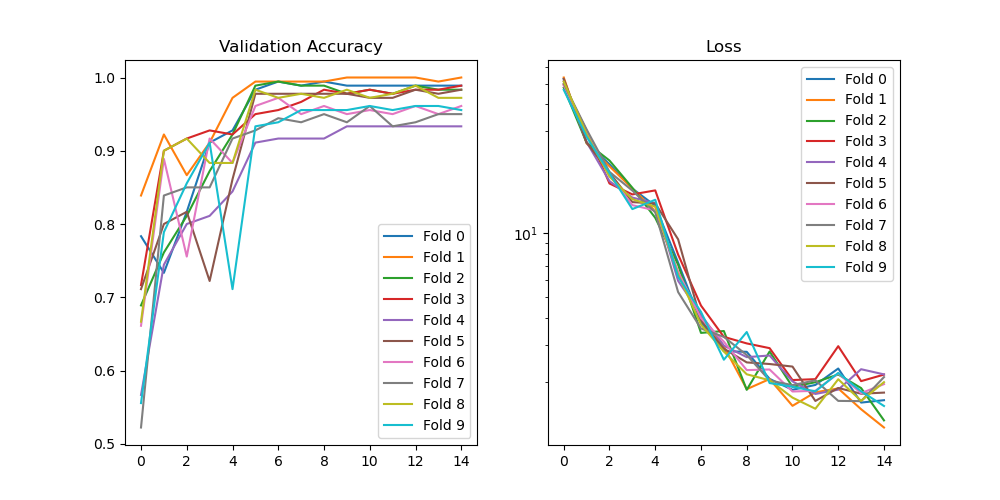

In [10]:
def plot_folds(data):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    for fold_i in range(len(data["epoch_acc"])):
        axes[0].plot(data["epoch_acc", fold_i], label=f"Fold {fold_i}")
        axes[0].legend()
        axes[0].set_title("Validation Accuracy")
        
        axes[1].plot(data["loss", fold_i], label=f"Fold {fold_i}")
        axes[1].set_yscale("log")
        axes[1].legend()
        axes[1].set_title("Loss")
        
plot_folds(data)
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix

To evaluate the model's strengths and weaknesses I visualize an interactive confusion matrix. Click on a misclasified square to cycle through corresponding images (correctly classified samples are not included to avoid high memory usage).

The confusion matrix gives a few insights into where the model has trouble. The model misclassifies 5 of the Will Smith samples as Denzel Washington, the most out of any true/predicted pair. This aligns with the information from our classification report above showing that Will Smith has the lowest metrics with only a 0.91 f1-score.

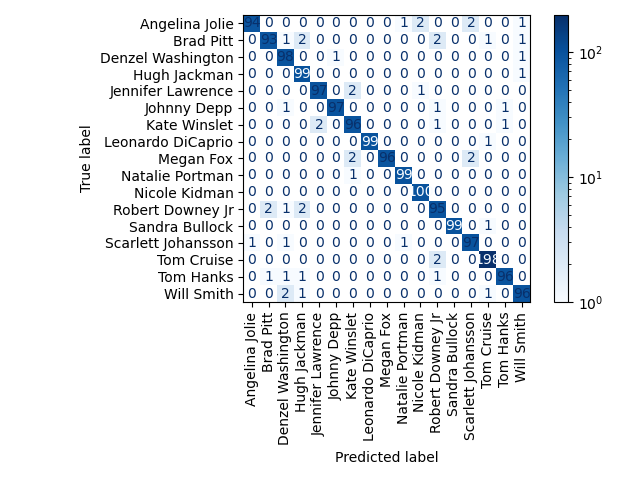

In [11]:
from VisUtils import IConfusionMatrixDisplay

# +
#https://stackoverflow.com/questions/42867400/python-show-image-upon-hovering-over-a-point

img_matrix = [[[] for _ in range(len(classes))] for _ in range(len(classes))]
for true, pred, img in zip(mis_true, mis_preds, mis_imgs):
    img_matrix[true][pred].append(img)

cm = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds, 
    display_labels=classes,
    cmap="Blues",
    im_kw={"norm": "log"},
    xticks_rotation="vertical"
)
plt.tight_layout()

IConfusionMatrixDisplay(plt.gcf(), cm.ax_, img_matrix)

# References
<a id='references'></a>

[1] J. Deng, J. Guo, E. Ververas, I. Kotsia, and S. Zafeiriou, “Retinaface: Single-shot multi-level face localisation in the wild,” 2020 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Jun. 2020. doi:10.1109/cvpr42600.2020.00525 

[2] F. Schroff, D. Kalenichenko, and J. Philbin, “FaceNet: A unified embedding for face recognition and clustering,” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pp. 815–823, Jun. 2015. doi:10.1109/cvpr.2015.7298682 

[3] S. Yang, P. Luo, C. C. Loy, and X. Tang, “Wider face: A face detection benchmark,” 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Jun. 2016. doi:10.1109/cvpr.2016.596 

[4] A. Zhuchkov, “Analyzing the effectiveness of image augmentations for face recognition from limited data,” 2021 International Conference “Nonlinearity, Information and Robotics” (NIR), pp. 1–6, Aug. 2021. doi:10.1109/nir52917.2021.9666135 

[5] C. Szegedy et al., “Going deeper with convolutions,” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pp. 1–9, Jun. 2015. doi:10.1109/cvpr.2015.7298594 

[6] Q. Cao, L. Shen, W. Xie, O. M. Parkhi, and A. Zisserman, “VGGFACE2: A dataset for recognising faces across pose and age,” 2018 13th IEEE International Conference on Automatic Face & Gesture Recognition (FG 2018), May 2018. doi:10.1109/fg.2018.00020 

